In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os

import desispec.io
import fitsio
from desispec.coaddition import coadd_cameras
from desimodel.footprint import radec2pix
from scipy.signal import medfilt

from IPython.display import clear_output

first_line_wave=2796.3543
second_line_wave=2803.5315


plt.rcParams.update({'font.size': 20})

In [2]:
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
def smooth_spectra(y_flx,smooth_strength):
    #set up kernel using given strength
    kernel = Gaussian1DKernel(stddev=smooth_strength)
    #smooth spectra
    y_smooth=convolve(y_flx,kernel)
    
    return(y_smooth)

In [4]:
first_line_wave=2796.3543
second_line_wave=2803.5315
rf_line_sep=second_line_wave-first_line_wave

def MgII_Model(theta,x):
    a1,a2,s1,s2,b,m,z=theta
    #determine peak centers
    
    m1=(z+1)*first_line_wave
    m2=(z+1)*second_line_wave
    
    #Generate Model
    model = m*(x-x[0]) +b + a1*np.exp((-(x-m1)**2)/(2*s1**2))+a2*np.exp((-(x-m2)**2)/(2*s2**2))
    return model

def plot_abs_spectra(spectra,z_abs=0,title=''):
    x_spc=spectra.wave['brz']
    y_flx=smooth_spectra(spectra.flux['brz'][0],2)
    y_err=1/np.sqrt(spectra.ivar['brz'][0])

    plt.figure(figsize=(20,5))
    plt.plot(x_spc,y_flx,alpha=0.8)
    plt.plot(x_spc,y_err,alpha=0.8)
    plt.title(title)

    plt.xlim(x_spc[0],x_spc[-1])
    
    bot=np.min([0.0,np.percentile(y_flx,0.1)])
    plt.ylim(bot,np.percentile(y_flx,99.9))
    
    plt.xlabel('Flux')
    plt.ylabel('Wavelength (Å)')
    
    if(len(z_abs)>0):
        for z in z_abs:
            plt.fill_betweenx([-100,100], first_line_wave*(1+float(z))-50, x2=second_line_wave*(1+float(z))+30, alpha=0.2, color='gray')
    else:
        plt.fill_betweenx([-100,100], first_line_wave*(1+float(z_abs))-50, x2=second_line_wave*(1+float(z_abs))+30, alpha=0.2, color='gray')

    plt.show()
    
def plot_abs_spec_fancy(en,survey):
    spec=get_spec_healpix(en['TARGETID'],radec2pix(64,en['RA'],en['DEC']),survey)
    
    x_spc=spec.wave['brz']
    y_flx=spec.flux['brz'][0]
    y_err=1/np.sqrt(spec.ivar['brz'][0])
    
    
    z_MgII=en['Z_MGII']
    
    high_wave=(z_MgII+1)*second_line_wave+en['STDDEV_2803']*5
    low_wave= (z_MgII+1)*first_line_wave-en['STDDEV_2796']*5
    
    #recast into index space for slicing, 2 is a fudge factor for low StdDev peaks
    prh=min(len(x_spc)-1, int(np.round((high_wave-3600)/0.8))+5)
    prl=max(0, int(np.round((low_wave-3600)/0.8))-5)
    #peak subset
    peak_wave=x_spc[prl:prh]
    peak_flx=y_flx[prl:prh]
    peak_err=y_err[prl:prh]
    
    #make models from MCMC output
    #a1,a2,s1,s2,b,m,z=theta
    params=[en['AMP_2796'],en['AMP_2803'],en['STDDEV_2796'],en['STDDEV_2803'],en['INTERCEPT'],en['SLOPE'],z_MgII]
    cen_fit_model = MgII_Model(params,peak_wave)

    cont_est = medfilt(y_flx,19)
    
    plt.rcParams.update({'font.size': 16})
    cen=int(np.round(((1+z_MgII)*2799-3600)/0.8))
    f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]},figsize=(20,6.5))

    a0.plot(x_spc, y_flx,label='Data')
    a0.plot(x_spc, y_err,label='Error Spectrum')
    a0.plot(x_spc, cont_est,label='Median Filter')
    a0.set_title('TargetID = '+str(en['TARGETID'])+' Pipeline Redshift = '+str(np.round(en['Z_QSO'],3))+'  Mg-II Abs Redshift = '+str(z_MgII))
    a0.set_xlim(3600,9800)
    a0.set_ylim(np.percentile(y_flx,0.01),np.percentile(y_flx,99.9))
    a0.set_xlabel('Wavelength (Å)')
    a0.set_ylabel('Flux')

    a0.axvline((1+z_MgII)*2800,label='MgII',color='Magenta',alpha=0.5)

    a0.axvline((1+z_MgII)*1393.75,label='Si IV',color='DarkGrey',alpha=0.5)
    a0.axvline((1+z_MgII)*1402.77,color='DarkGrey',alpha=0.5)

    a0.axvline((1+z_MgII)*1548.187,label='C IV', color='Black',alpha=0.5)
    #a0.axvline((1+z_MgII)*1550.772,color='Black',alpha=0.5)
    a0.axvline((1+z_MgII)*2382.765,label='Fe II',color='Red',alpha=0.5)
    a0.axvline((1+z_MgII)*2600.173,color='Red',alpha=0.5)

    a1.plot(peak_wave,peak_flx)
    a1.plot(peak_wave,peak_err)
    a1.plot(peak_wave,cen_fit_model,c='C03',label='MCMC Derived Model')
    a1.set_xlim(peak_wave[0],peak_wave[-1])
    a1.set_ylim(np.percentile(peak_flx,0.01),np.percentile(peak_flx,99.9))
    a1.set_xlabel('Wavelength (Å)')
    a1.set_ylabel('Flux')

    f.tight_layout()
    plt.show()

In [5]:
def get_spec_healpix(targetid,healpix,survey):
    healpix=str(healpix)
    targetid=int(targetid)
    
    #form full file paths
    hp_dir=os.path.join(reduction_base_dir,'healpix',survey,'dark',healpix[0:-2],healpix)
    specfile=os.path.join(hp_dir,'coadd-{}-dark-{}.fits'.format(survey,healpix))

    if(os.path.exists(specfile)):
        #read fibermap and specobj seperately? (TODO: could this be combined?)
        specobj = desispec.io.read_spectra(specfile)
        
        specobj_idx=np.where(specobj.target_ids() == targetid)
        
        return(coadd_cameras(specobj[specobj_idx]))

In [6]:
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
plt.rcParams.update({'font.size': 20})

#Elliptical Selection Params
h,k,a,b,A=[1.2,1.2,1,1.2,np.pi/3]

def purity_cuts(MgII_cat,pre_ellip_cut=False,verbose=True):
    
    #record inital size for later comparison
    int_size=len(MgII_cat)
    
    #first cut positive amplitudes
    MgII_cat=MgII_cat[MgII_cat['AMP_2796']<0]
    MgII_cat=MgII_cat[MgII_cat['AMP_2803']<0]
    
    #Print results and save new catalog size
    if(verbose):
        print('Result of Positive Amplitude Cuts: {} systems removed'.format(int_size-len(MgII_cat)))
    sec_size=len(MgII_cat)
    
    #next cut large negative spikes
    #MgII_cat=MgII_cat[(np.abs(MgII_cat['AMP_2796'])<4*MgII_cat['INTERCEPT'])]
    #MgII_cat=MgII_cat[(np.abs(MgII_cat['AMP_2803'])<4*MgII_cat['INTERCEPT'])]
    
    #Print results and save new catalog size
    #if(verbose):
    #    print('Result of Large Negative Spike Cuts: {} systems removed'.format(sec_size-len(MgII_cat)))
    ter_size=len(MgII_cat)
    
    #Finally perform elliptical selection
    xt = MgII_cat['AMP_2796']/MgII_cat['AMP_2803']
    yt = MgII_cat['STDDEV_2796']/MgII_cat['STDDEV_2803']

    #gives number of systems post initial cuts that lie outside selection
    ellipse_mask=((xt-h)*np.cos(A)+(yt-k)*np.sin(A))**2/a**2+((xt-h)*np.sin(A)-(yt-k)*np.cos(A))**2/b**2>1

    #resulting #systems given by 
    if(verbose):
        print('Result of Elliptical Cuts: {} systems removed'.format(np.sum(ellipse_mask)))
        print('Result of Purity Cuts: {} systems removed of initial {}\n'.format(int_size-ter_size+np.sum(ellipse_mask),int_size))
    
    #return catalog results before elliptical cuts for purposes of plotting and actual number of systems post-cut for numbers
    if(pre_ellip_cut):
        return(MgII_cat,int_size-(int_size-ter_size+np.sum(ellipse_mask)))
    else:
        return(MgII_cat[~ellipse_mask])

/tmp/ipykernel_44976/2389417809.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


101201 total QSOs
Removing 0 physically impossible absorption systems
Removing 3665 associated absorption systems
Result of Positive Amplitude Cuts: 0 systems removed
Result of Elliptical Cuts: 0 systems removed
Result of Purity Cuts: 0 systems removed of initial 17145

Total number of QSO spectra searched: 101201
Total number of MgII absorption systems detected: 17145
Percentage of QSO spectra with MgII absorbers: 11.886246183338109%
Expected number of MgII absorbers per QSO spectra: 0.16941532198298437


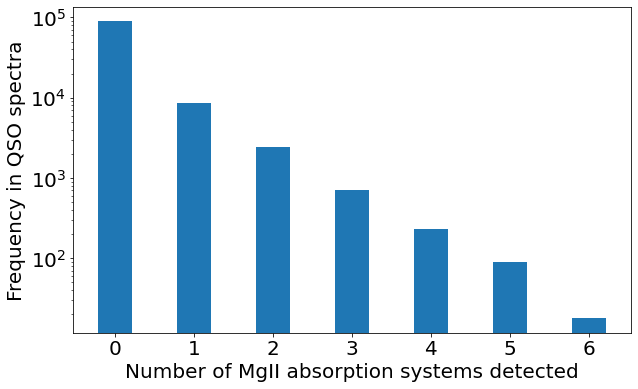

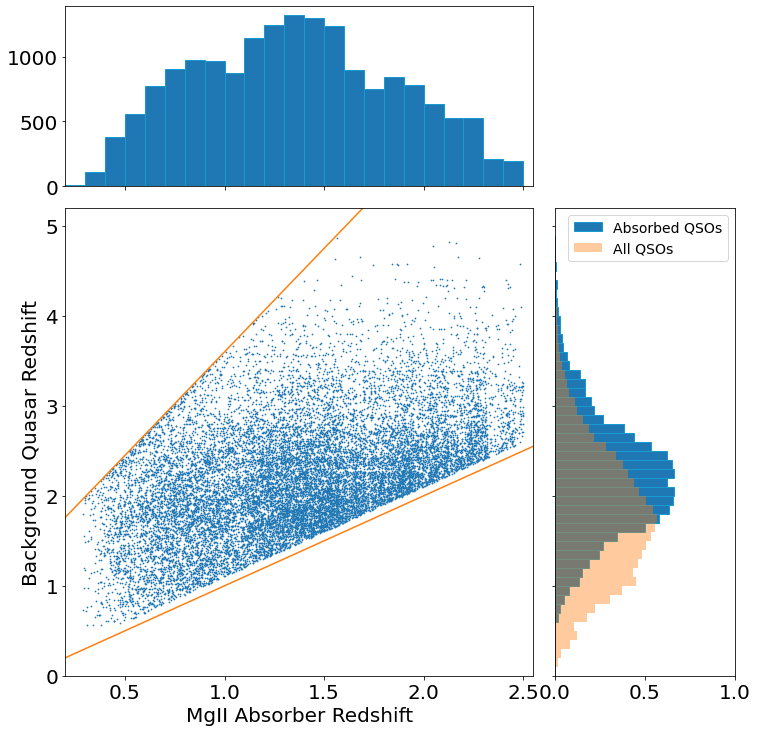

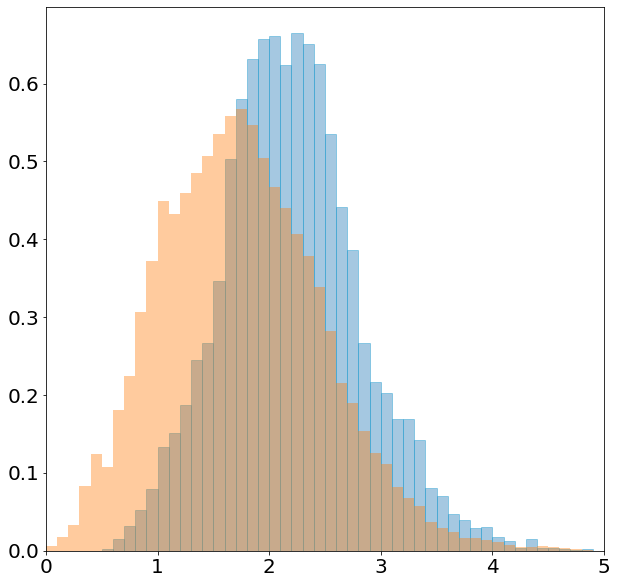

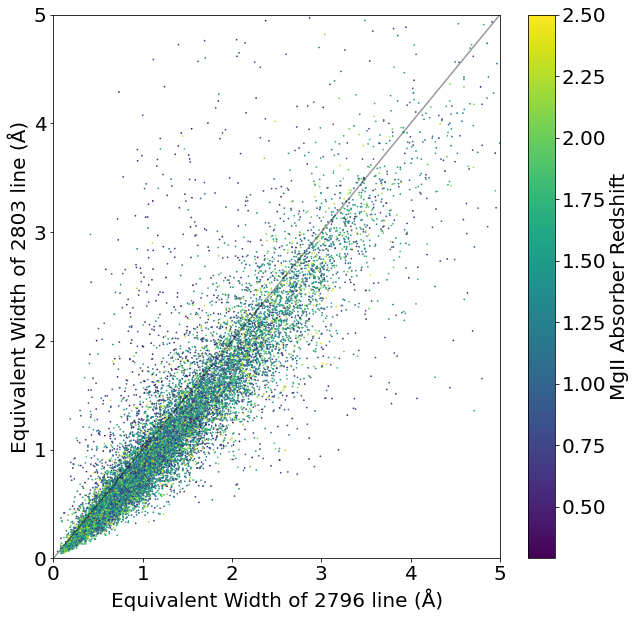

In [8]:
redux='fuji'
ndim=7

#file access setup
Mgii_fp='/global/cfs/cdirs/desi/users/lucasnap/MgII-Absorbers-{}.fits'.format(redux)
reduction_base_dir='/global/cfs/cdirs/desi/spectro/redux/{}/'.format(redux)

#getting all qso redshifts
QSOcat_fp='/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{}/QSO_cat_{}_healpix_for_lyalpha.fits'.format(redux,redux)
#QSOcat_fp='/global/cfs/cdirs/desi/users/edmondc/QSO_catalog/{}/QSO_cat_fuji_healpix.fits'.format(redux)

QSOcat=fitsio.read(QSOcat_fp,'QSO_CAT')
print('{} total QSOs'.format(len(QSOcat)))

QSO_cat_allz=QSOcat['Z']


plt.rcParams.update({'font.size': 20})


#write catalog filenames based on survey
Mgii_cat_fn='MgII-Absorbers.fits'

#open MgII abs summary cat
MgII_cat=fitsio.read(Mgii_fp,'MGII_ABSORBERS')

#removing physically impossible systems
print('Removing {} physically impossible absorption systems'.format(np.sum((MgII_cat['Z_MGII']>0.05+MgII_cat['Z_QSO']))))
MgII_cat=MgII_cat[~(MgII_cat['Z_MGII']>0.05+MgII_cat['Z_QSO'])]

MgII_cat=purity_cuts(MgII_cat)

MgII_abs_unique_targetid, MgII_abs_counts = np.unique(MgII_cat['TARGETID'], return_counts=True)


#
print('Total number of QSO spectra searched: {}'.format(len(QSO_cat_allz)))
print('Total number of MgII absorption systems detected: {}'.format(len(MgII_cat)))

print('Percentage of QSO spectra with MgII absorbers: {}%'.format(100*len(MgII_abs_unique_targetid)/len(QSO_cat_allz)))
print('Expected number of MgII absorbers per QSO spectra: {}'.format(len(MgII_cat)/len(QSO_cat_allz)))

plt.figure(figsize=(10,6))
plt.hist(MgII_abs_counts,rwidth=0.85,log=True,bins=np.arange(0,7,0.5),align='left')
plt.hist(x=np.zeros(len(QSO_cat_allz)-len(MgII_abs_unique_targetid)),rwidth=0.85,color='C00',bins=np.arange(0,7,0.5),align='left')
plt.xlabel('Number of MgII absorption systems detected')
plt.ylabel('Frequency in QSO spectra')
plt.show()

#all from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
#spacing /location stuff of plot elements
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03

right_plot_width=1.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.25]
rect_histy = [left + width + spacing, bottom, 0.25, height]

fig = plt.figure(figsize=(10,10))

#add axes
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

#disable overlapping axis labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#main plot
ax.scatter(MgII_cat['Z_MGII'],MgII_cat['Z_QSO'],s=0.5)
x=np.arange(0,2.6,0.01)
ax.plot(x,x,c='C01')
ax.plot(x,(x+1)*first_line_wave/1216-1,c='C01')

ax.set_ylabel('Background Quasar Redshift')
ax.set_xlabel('MgII Absorber Redshift')
ax.set_ylim(0,5.2)
ax.set_xlim(0.2,2.55)

#Histogram setup
binwidth = 0.1
xymax = max(np.max(np.abs(MgII_cat['Z_MGII'])), np.max(np.abs(MgII_cat['Z_QSO'])))
lim = (int(xymax/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)

#Adding histograms
ax_histx.hist(MgII_cat['Z_MGII'], bins=bins, edgecolor='#169acf')
ax_histy.hist(MgII_cat['Z_QSO'], bins=bins, orientation='horizontal', edgecolor='#169acf',density=True,label='Absorbed QSOs')
ax_histy.hist(QSO_cat_allz,alpha=0.4,density=True,bins=bins,label='All QSOs',orientation='horizontal')
ax_histy.legend(fontsize=14)

#replacing histogram labels to avoid overlapping #s
#ax_histx.set_yticks([0,250,500])
#ax_histx.set_yticklabels(['','250','500'])

ax_histy.set_xticks([0,0.5,1])
#ax_histy.set_xticklabels(['','250','500'])

plt.show()

plt.figure(figsize=(10,10))
plt.hist(MgII_cat['Z_QSO'],bins=bins,edgecolor='#169acf',alpha=0.4,density=True)
plt.hist(QSO_cat_allz,alpha=0.4,density=True,bins=bins)

plt.xlim(0,5)
plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(MgII_cat['TSNR2'],MgII_cat['EW_2796'],s=0.5)
#plt.xlabel('FLUX_R')
#plt.ylabel('EW_2796')
#plt.xlim(-1,100)
#plt.ylim(-1,20)
#plt.show()

#plt.figure(figsize=(10,10))
#plt.scatter(MgII_cat['AMP_2796']/MgII_cat['AMP_2803'],MgII_cat['STDDEV_2796']/MgII_cat['STDDEV_2803'],s=0.5)
#plt.xlabel('Line Amplitude Ratio')
#plt.ylabel('Line Width Ratio')
#plt.xlim(-1,4)
#plt.ylim(0,4)
#plt.show()


plt.figure(figsize=(10,10))

x=np.arange(0,8,0.01)
plt.plot(x,x,c='black',alpha=0.4)

plt.scatter(MgII_cat['EW_2796'],MgII_cat['EW_2803'],s=0.5,c=MgII_cat['Z_MGII'])
plt.colorbar(label='MgII Absorber Redshift')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Equivalent Width of 2796 line (Å)')
plt.ylabel('Equivalent Width of 2803 line (Å)')
plt.show()
    


'''for many_abs in MgII_abs_unique_targetid[np.where(MgII_abs_counts>6)]:
    #print(np.where(MgII_cat['TARGETID']==many_abs))
    abs_entry=MgII_cat[np.where(MgII_cat['TARGETID']==many_abs)[0][0]]

    z_absorbers=MgII_cat[np.where(MgII_cat['TARGETID']==many_abs)[0]]['Z_MGII']

    #print(abs_entry['TARGETID'])
    plt_title='{}     z_MgII:{}     z_QSO:{}'.format(abs_entry['TARGETID'],abs_entry['Z_MGII'],abs_entry['Z_QSO'])
    spectra=get_spec_healpix(abs_entry['TARGETID'],radec2pix(64,abs_entry['RA'],abs_entry['DEC']),survey)

    plot_abs_spectra(spectra,z_abs=z_absorbers,title=plt_title)''';

Total number of QSO spectra with >4 MgII absorption systems: 435

0.029973127540825466


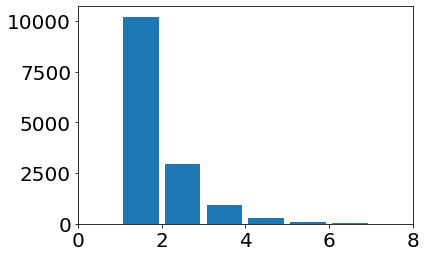

14513


In [14]:
MgII_abs_unique_targetid, MgII_abs_counts = np.unique(MgII_cat['TARGETID'], return_counts=True)

print('Total number of QSO spectra with >4 MgII absorption systems: {}\n'.format(np.sum(MgII_abs_counts>3)))

print(np.sum(MgII_abs_counts>3)/len(MgII_abs_counts))

plt.hist(MgII_abs_counts,rwidth=0.85)
plt.xlim(0,8)
plt.show()

print(len(MgII_abs_counts))

1.2156967549058515


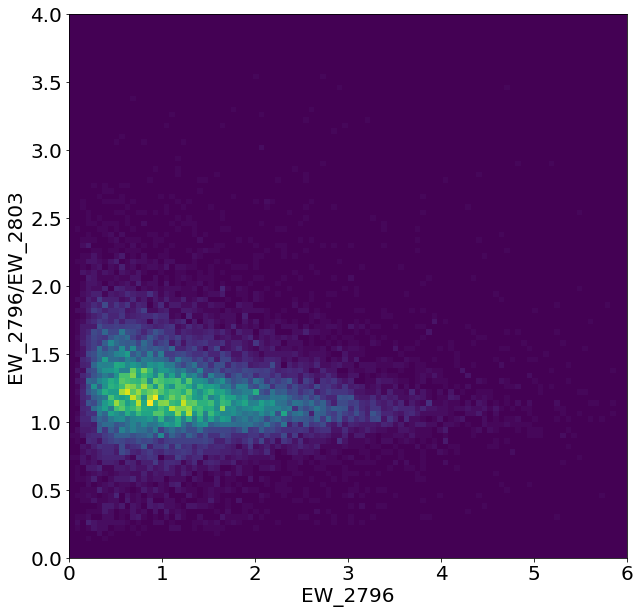

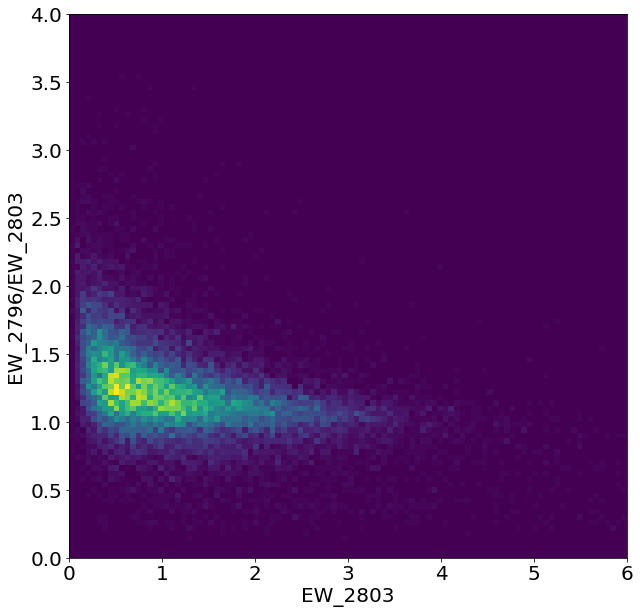

In [13]:
redux='fuji'
reduction_base_dir='/global/cfs/cdirs/desi/spectro/redux/{}/'.format(redux)

Mgii_fp='/global/cfs/cdirs/desi/users/lucasnap/MgII-Absorbers-{}.fits'.format(redux)

#open MgII abs summary cat
MgII_cat=fitsio.read(Mgii_fp,'MGII_ABSORBERS')

print(np.mean(MgII_cat['EW_2796']/MgII_cat['EW_2803']))


plt.figure(figsize=(10,10))
plt.hist2d(MgII_cat['EW_2796'],MgII_cat['EW_2796']/MgII_cat['EW_2803'],range=[[0,6],[0,4]],bins=100)
plt.xlabel('EW_2796')
plt.ylabel('EW_2796/EW_2803')
plt.show()

plt.figure(figsize=(10,10))
plt.hist2d(MgII_cat['EW_2803'],MgII_cat['EW_2796']/MgII_cat['EW_2803'],range=[[0,6],[0,4]],bins=100)
plt.xlabel('EW_2803')
plt.ylabel('EW_2796/EW_2803')
plt.show()